# Explainatory Notebook
The Goal of this Notebook is to Explain the thought process we went through , and the methods, and models we used while creating our project. The final Evaluation is in the word document.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from NewsSentiment import TargetSentimentClassifier
from scipy.signal import savgol_filter

# Framework for Runs- Neptune.ai

Firstly early on in the project, we understood that this project would include many different models, and a lot of trial and error, so before diving into the itty gritty of all of the "algorithmic work", we created an MLOps Platform, Neptune.ai to help us make sense of everything. 

![Screen%20Shot%202023-03-05%20at%2022.40.04.png](attachment:Screen%20Shot%202023-03-05%20at%2022.40.04.png)

https://app.neptune.ai/o/applied-ml-project/org/senti-trends/experiments?compare=IwTgzANArMQ&split=bth&dash=images&viewId=988d51b9-f034-4161-b682-06635e597be1&sortBy=%5B%22sys%2Fmonitoring_time%22%5D&sortDirection=%5B%22descending%22%5D&sortFieldType=%5B%22int%22%5D&sortFieldAggregationMode=%5B%22auto%22%5D&suggestionsEnabled=true&lbViewUnpacked=true

# Aquiring the Data

## 1. News API

![image.png](attachment:image.png)


### only one month of data for the free:
![image.png](attachment:image-2.png)

### Might be too slow
**request requires pagination:**  
  
![image.png](attachment:image-2.png)

  
**and then requires scraping for every article independently**
  
![image.png](attachment:image.png)

*****************TODO: Explanation of dificulties

## 2. Implement ourself

## Meet our `Scraper`

**class for for every source we need:**
  
 ![image.png](attachment:image-2.png)

**that uses the source internal API:**  
  
 ![image.png](attachment:image.png)

## scraping at scale: `CNN`
  
  **cnn returns the entire content of every article in history! (actually, about 3 years of data)**  
  
  ![image.png](attachment:image.png)

  
 **articles about netanyhu**:  
   
 ![image.png](attachment:image-2.png)
  
  
    
 **saved to csv in 20 seconds**


![SegmentLocal](scrape.gif "segment")

## Handling bugs: `FOX`

**if page number is larger then 100, it explodes ! what can we do?**  
  
*query one month at a time and hope there's less then 100 articles in a signle month*  
*which wasn't fun*  
![image.png](attachment:image.png)

# Sentiment Analysis

## Vader NLTK model

"The VADER sentiment lexicon is sensitive to both the polarity and the intensity of sentiments expressed in social media contexts, and is also generally applicable to sentiment analysis in other domains."<br><br>
Returns distribution (not probability!!) of neg, pos, neu words, and compound score- which is the sentiment the model sees.
## Example:

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize

sentences = ["VADER is smart, handsome, and funny.",  # positive sentence example
             "VADER is smart, handsome, and funny!",  # punctuation emphasis handled correctly (sentiment intensity adjusted)
             "VADER is very smart, handsome, and funny.", # booster words handled correctly (sentiment intensity adjusted)
             "VADER is VERY SMART, handsome, and FUNNY.",  # emphasis for ALLCAPS handled
             "VADER is VERY SMART, handsome, and FUNNY!!!", # combination of signals - VADER appropriately adjusts intensity
             "VADER is VERY SMART, uber handsome, and FRIGGIN FUNNY!!!", # booster words & punctuation make this close to ceiling for score
             "VADER is not smart, handsome, nor funny.",  # negation sentence example
             "The book was good.",  # positive sentence
             "At least it isn't a horrible book.",  # negated negative sentence with contraction
             "The book was only kind of good.", # qualified positive sentence is handled correctly (intensity adjusted)
             "The plot was good, but the characters are uncompelling and the dialog is not great.", # mixed negation sentence
             "Today SUX!",  # negative slang with capitalization emphasis
             "Today only kinda sux! But I'll get by, lol", # mixed sentiment example with slang and constrastive conjunction "but"
             "Make sure you :) or :D today!",  # emoticons handled
             "Not bad at all"  # Capitalized negation
             ]

analyzer = SentimentIntensityAnalyzer()
for sentence in sentences:
    vs = analyzer.polarity_scores(sentence)
    print("{:-<55} {}".format(sentence, str(vs)))

### Twist, we need to find sentiment of *object* in an Article 

In [ ]:
df = pd.read_csv('../data/output_data/cnn_trump_nltk_sentences_sentiment.csv')

In [ ]:
df = df.loc[(df['compound_s'] < -0.7) & (df['compound'] > 0.7)]

In [ ]:
df

In [ ]:
article = df.loc[2153, 'text']

In [ ]:
df.loc[2153, 'title']

In [ ]:
vs = analyzer.polarity_scores(article)
print("{:-<30} {}".format("Article Score", str(vs)))

In [ ]:
sentences = sent_tokenize(article)

In [ ]:
sentences

As we can see, this article talks moslty about how Zelenski and Europe wants peace, so there is positive sentiment on the whole text. But what about Trump?

In [ ]:
relevant = []
for sentence in sentences:
    if 'trump' in sentence.lower():
        relevant.append(sentence)
relevant

In [ ]:
for sentence in relevant:
    vs = analyzer.polarity_scores(sentence)
    print("{:-<55} {}".format(sentence +" \n", str(vs)))

From what we can find, he is referenced once in the Article, in a very low sentimented sentence. But is this enough? We would like to find the specific sentiment in the sentence towards the object as well! (And not just the general sentiment of the sentence)

# ABSA - Aspect Based Santiment Analysis
Also called *target based* sentiment analysis

Finds the specific Sentiment toward an object in a sentence
## Example:

In [ ]:
tsc = TargetSentimentClassifier()


In [ ]:
get_label = lambda res: max(res, key=lambda class_pred: class_pred['class_prob'])['class_label']

In [ ]:
res = tsc.infer_from_text("I don't like ", "trump", ", he is a bad person")
get_label(res)

In [ ]:
res = tsc.infer_from_text("I like biden very much, but ", "trump", ", is a bad person")
get_label(res)

In [ ]:
res = tsc.infer_from_text("I hate biden very much, but ", "trump", ", is simply the best")
get_label(res)

In [ ]:
res

In [ ]:
cur_color = "#06cc1d"
dis_color = "#399944"

So as we can see ABSA helps us find a precise sentiment towards an object in a sentence. But there is still another problem- How do we know we found all of the sentences with the object? What if Trump was called "The Former President", or "He"?

# Co-Reference Resolution (Pre processing Method)

To Apply coreference resolution we used spacy-expiremental Library.

![image.png](attachment:image.png)

In [ ]:
vs = analyzer.polarity_scores(article)
print("{:-<30} {}".format("Article Score", str(vs)))

In [ ]:
sentences = sent_tokenize(article)

In [ ]:
sentences

In [ ]:
coref = pd.read_csv('../data/preprocessed_data/cnn_netanyahu_coref.csv')
no_coref = pd.read_csv('../data/cnn-articles-netanyahu.csv')

In [ ]:
coref.occurences = coref.text.apply(lambda x: x.lower().count('netanyahu'))
no_coref.occurences = no_coref.text.apply(lambda x: x.lower().count('netanyahu'))
pass

In [ ]:
coref_1 = no_coref.occurences[:20]
coref_1 = coref_1.rename('before_coref')
coref_2 = coref.occurences[:20]
coref_2 = coref_2.rename('after_coref')
df = pd.concat([coref_1, coref_2], axis=1)

In [ ]:
df.plot(kind="bar")

So we can see that the amount of occurences of trump per article went up by a lot!<br>
Lets see how this works:

![Screen%20Shot%202023-03-05%20at%2021.02.13.png](attachment:Screen%20Shot%202023-03-05%20at%2021.02.13.png)

![Screen%20Shot%202023-03-05%20at%2021.02.40.png](attachment:Screen%20Shot%202023-03-05%20at%2021.02.40.png)

In [ ]:
coref[coref.occurences > 50][coref.title.str.startswith('Biden, staring down first Mideast crisi')]

In [ ]:
text = coref[coref.occurences > 50][coref.title.str.startswith('Biden, staring down first Mideast crisi')].text.values[0]

In [ ]:
text[0:55]

![image.png](attachment:image.png)

In [ ]:
loc = text.find("netanyahu credited netanyahu")
text[loc-30:loc+60]

![image.png](attachment:image.png)

So as we can see Coreference Resolution helps us find additional places where the relevant object is mentioned, but it may also miss, and add too many places- refering to different objects.

# TimeSeries Sentiment

We find a sentiment per article, but in order to compare we need to find a method top put sentiment in a timeseries

# In-article normalization

In [ ]:
cnn = pd.read_csv('../data/output_data/netanyahu_cnn_news_sentiment_not_norm.csv')
fox = pd.read_csv('../data/output_data/netanyahu_fox_news_sentiment_not_norm.csv')


### Best and Worst By ABSA:

In [ ]:
worst_precentile = cnn.compound_s.quantile(0.1)
best_precentile = cnn.compound_s.quantile(0.9)
print("worst_precentile (10%): ", worst_precentile, ". best_precentile (10%): ", best_precentile)

best_precentile = cnn.compound_s.quantile(0.95)
print("best_precentile (5%): ", best_precentile)

cnn[cnn.compound_s < worst_precentile].loc[:, ('title', 'compound_s')].values

In [ ]:
cnn[cnn.compound_s > best_precentile].loc[:, ('title', 'compound_s')].values

### only one occurence
![image.png](attachment:image.png)

### colors the entire article as -1.0 negative (worst possible)
![image.png](attachment:image-2.png)

So we would like to find articles that arent just with an extreme sentiment, but we would also like to address how central the object is in the article. To do this, we created a penalty on low occurunces:

### Low occurences penalty
![image.png](attachment:image-2.png)

In [ ]:
cnn = pd.read_csv('../data/output_data/netanyahu_cnn_news_sentiment.csv')
fox = pd.read_csv('../data/output_data/netanyahu_fox_news_sentiment.csv')


In [ ]:
worst_precentile = cnn.compound_s.quantile(0.1)
best_precentile = cnn.compound_s.quantile(0.9)
print("worst_precentile (10%): ", worst_precentile, ". best_precentile (10%): ", best_precentile)

best_precentile = cnn.compound_s.quantile(0.95)
print("best_precentile (5%): ", best_precentile)

cnn[cnn.compound_s < worst_precentile].loc[:, ('title', 'compound_s')].values

### Now it's way more clear
![image.png](attachment:image.png)

...

![image.png](attachment:image-2.png)

# Our Models

## 1. "Industry Standart" Model results

![image.png](attachment:image.png)

see [github repo](https://github.com/fhamborg/NewsMTSC) or [Hugging face page](https://huggingface.co/datasets/fhamborg/news_sentiment_newsmtsc)
  
and.. it's as easy as  
![image.png](attachment:image-2.png)

## 100 Netanyahu articles  

In [ ]:
def add_data_to_plot(axes, vendor1, vendor2, mean1, mean2, correlation):
    axes.text(0.02, 0.95, f'Correlation: {round(correlation,4)}',
                           fontdict={'size': 15, 'color':cur_color}, transform=axes.transAxes)
                
    axes.text(0.02, 0.92, f'Mean {vendor2}: {round(mean1,4)},',
                fontdict={'size': 10, 'color':dis_color}, transform=axes.transAxes)
    axes.text(0.02, 0.89, f'Mean {vendor1}: {round(mean2,4)}',
                fontdict={'size': 10, 'color':dis_color}, transform=axes.transAxes)
    return axes

### raw data

In [ ]:
def plot(df:pd.DataFrame, vendor, color='#4287f5'):
    df.date = pd.to_datetime(df.date)
    df = df.sort_values(by=['date'])
    axes = df.plot(x='date', y='compound_s', kind='line', title=f'{vendor} News Sentiment', figsize=(17,8), color=color)


def joined_plot(df1:pd.DataFrame, df2:pd.DataFrame, vendor1, vendor2, color1='#4287f5', color2='#f56342'):  
    df1.date = pd.to_datetime(df1.date)
    df2.date = pd.to_datetime(df2.date)
    df1 = df1.sort_values(by=['date']).rename(columns={'compound_s': vendor1})
    df2 = df2.sort_values(by=['date']).rename(columns={'compound_s': vendor2})
    mean1 = df1[vendor1].mean()
    mean2 = df2[vendor2].mean()
    correlation = df1[vendor1].corr(df2[vendor2])
    axes = df1.plot(x='date', y=vendor1, kind='line', title=f'{vendor1} and {vendor2} News Sentiment', color=color1 , figsize=(17,8))
    add_data_to_plot(axes, vendor1, vendor2, mean1, mean2, correlation)
    df2.plot(x='date', y=vendor2, kind='line', ax=axes, color=color2)
    df3 = pd.DataFrame({'date': df1.date, 'baseline': [0.0]*len(df1)}).plot(x='date', y='baseline', kind='line', ax=axes, color='#40464f', linestyle='--')

plot(cnn, 'CNN')
plot(fox, 'Fox', color='#f56342')
# joined_plot(cnn, fox, 'CNN', 'Fox')

As we can see, the Raw Data is full of noise, so we will show an aggregation by week and month.

### Median aggregation

### raw data

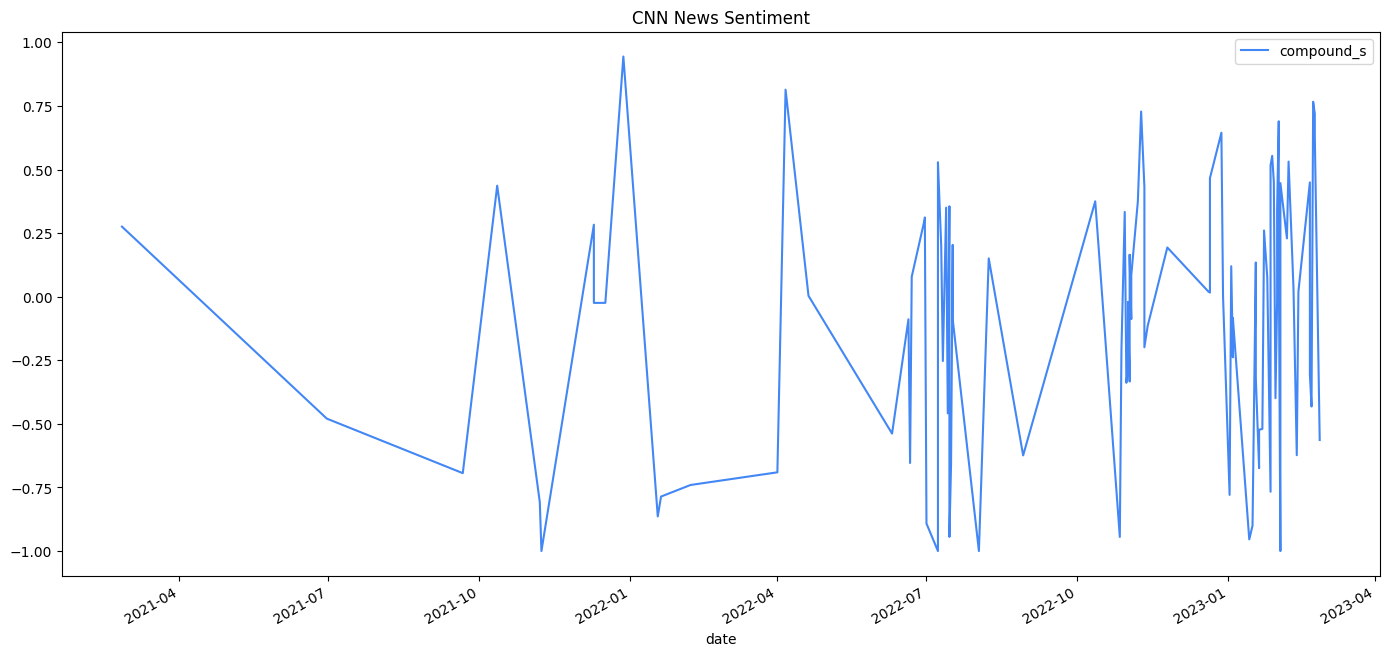

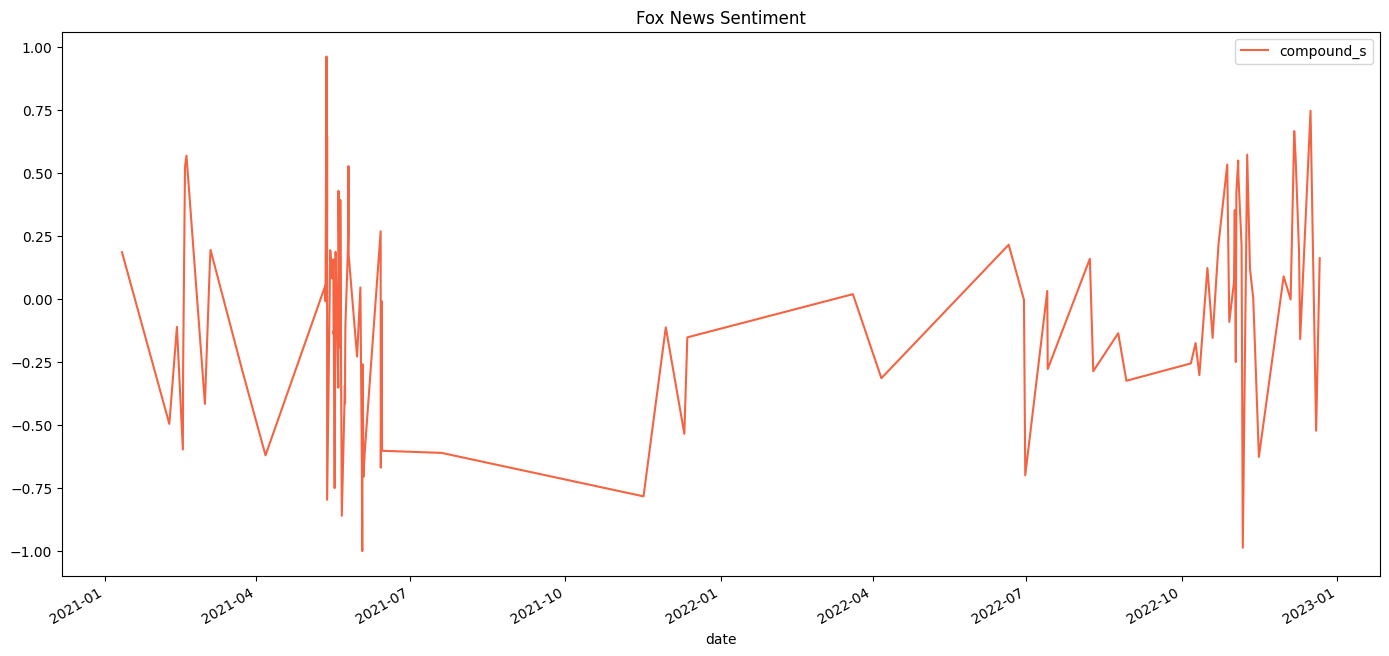

In [64]:
def plot(df:pd.DataFrame, vendor, color='#4287f5'):
    df.date = pd.to_datetime(df.date)
    df = df.sort_values(by=['date'])
    axes = df.plot(x='date', y='compound_s', kind='line', title=f'{vendor} News Sentiment', figsize=(17,8), color=color)


def joined_plot(df1:pd.DataFrame, df2:pd.DataFrame, vendor1, vendor2, color1='#4287f5', color2='#f56342'):  
    df1.date = pd.to_datetime(df1.date)
    df2.date = pd.to_datetime(df2.date)
    df1 = df1.sort_values(by=['date']).rename(columns={'compound_s': vendor1})
    df2 = df2.sort_values(by=['date']).rename(columns={'compound_s': vendor2})
    mean1 = df1[vendor1].mean()
    mean2 = df2[vendor2].mean()
    correlation = df1[vendor1].corr(df2[vendor2])
    axes = df1.plot(x='date', y=vendor1, kind='line', title=f'{vendor1} and {vendor2} News Sentiment', color=color1 , figsize=(17,8))
    add_data_to_plot(axes, vendor1, vendor2, mean1, mean2, correlation)
    df2.plot(x='date', y=vendor2, kind='line', ax=axes, color=color2)
    df3 = pd.DataFrame({'date': df1.date, 'baseline': [0.0]*len(df1)}).plot(x='date', y='baseline', kind='line', ax=axes, color='#40464f', linestyle='--')

plot(cnn, 'CNN')
plot(fox, 'Fox', color='#f56342')
# joined_plot(cnn, fox, 'CNN', 'Fox')

As we can see, the Raw Data is full of noise, so we will show an aggregation by week and month.

### Median aggregation

In [65]:
def add_week_month(df:pd.DataFrame):
    df['date'] = pd.to_datetime(df['date'])
    df['week'] = df['date'].dt.year.astype(str) + '-'  + df['date'].dt.week.astype(str) 
    df['month'] = df['date'].dt.year.astype(str) + '-' + df['date'].dt.month.astype(str) 
    return df

cnn = add_week_month(cnn)
fox = add_week_month(fox)


/var/folders/99/x78qd8fj5w30t93n516mvb3w0000gn/T/ipykernel_5059/1222786786.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['week'] = df['date'].dt.year.astype(str) + '-'  + df['date'].dt.week.astype(str)
/var/folders/99/x78qd8fj5w30t93n516mvb3w0000gn/T/ipykernel_5059/1222786786.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['week'] = df['date'].dt.year.astype(str) + '-'  + df['date'].dt.week.astype(str)


/var/folders/99/x78qd8fj5w30t93n516mvb3w0000gn/T/ipykernel_5059/2029801910.py:25: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df1 = df1.groupby('week').median().rename(columns={'compound_s': vendor1})
/var/folders/99/x78qd8fj5w30t93n516mvb3w0000gn/T/ipykernel_5059/2029801910.py:25: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df1 = df1.groupby('week').median().rename(columns={'compound_s': vendor1})
/var/folders/99/x78qd8fj5w30t93n516mvb3w0000gn/T/ipykernel_5059/2029801910.py:25: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_on

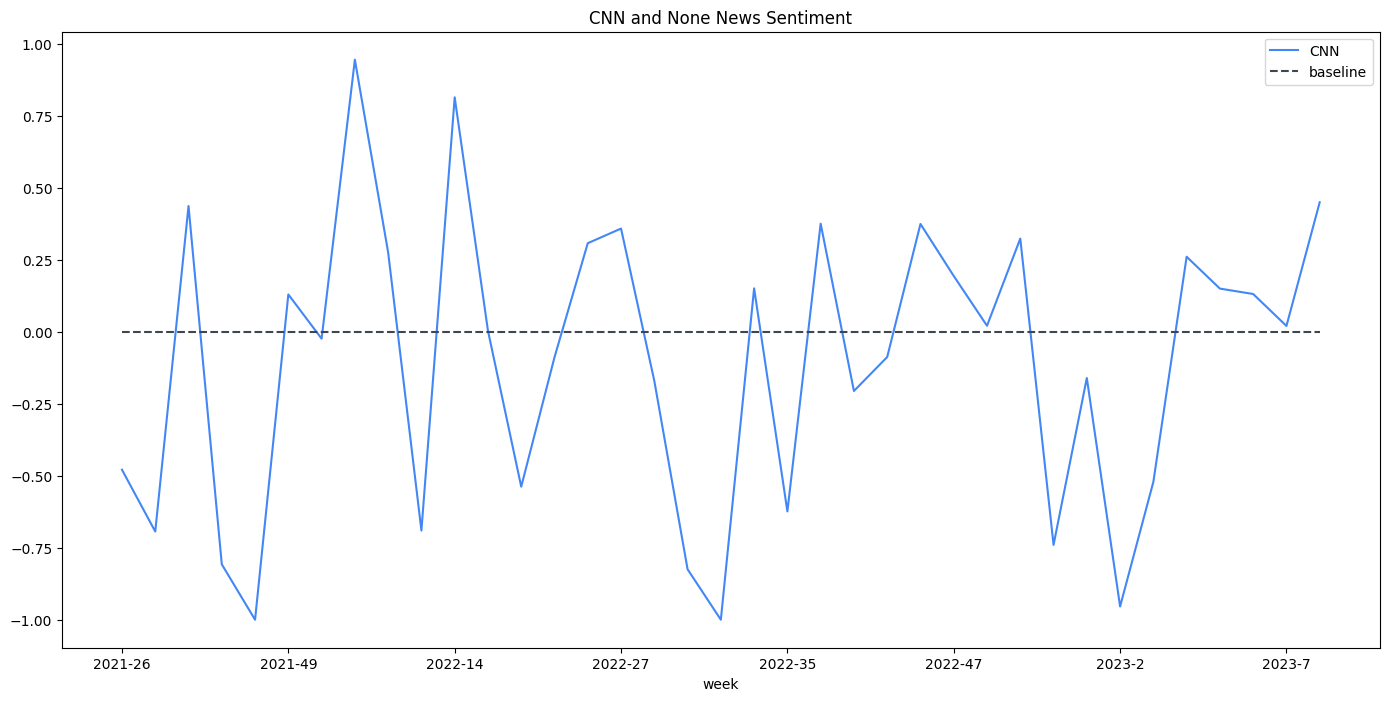

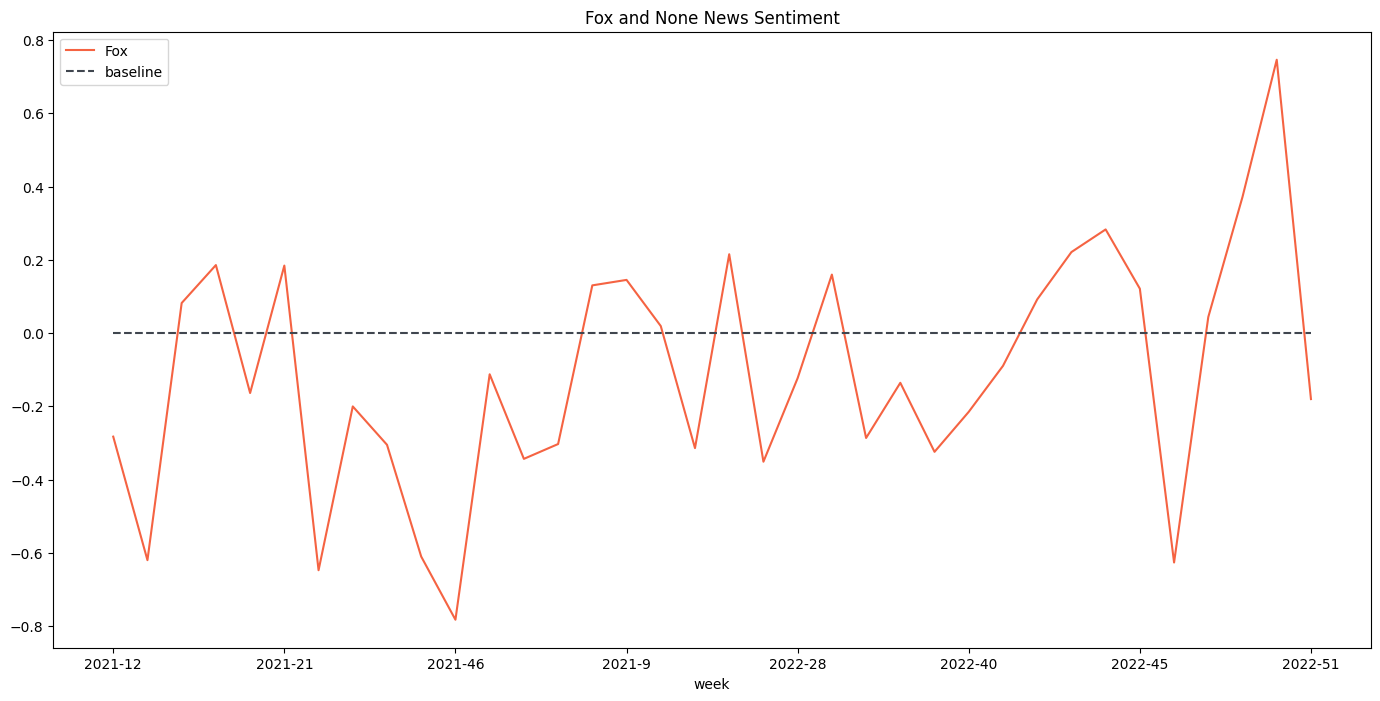

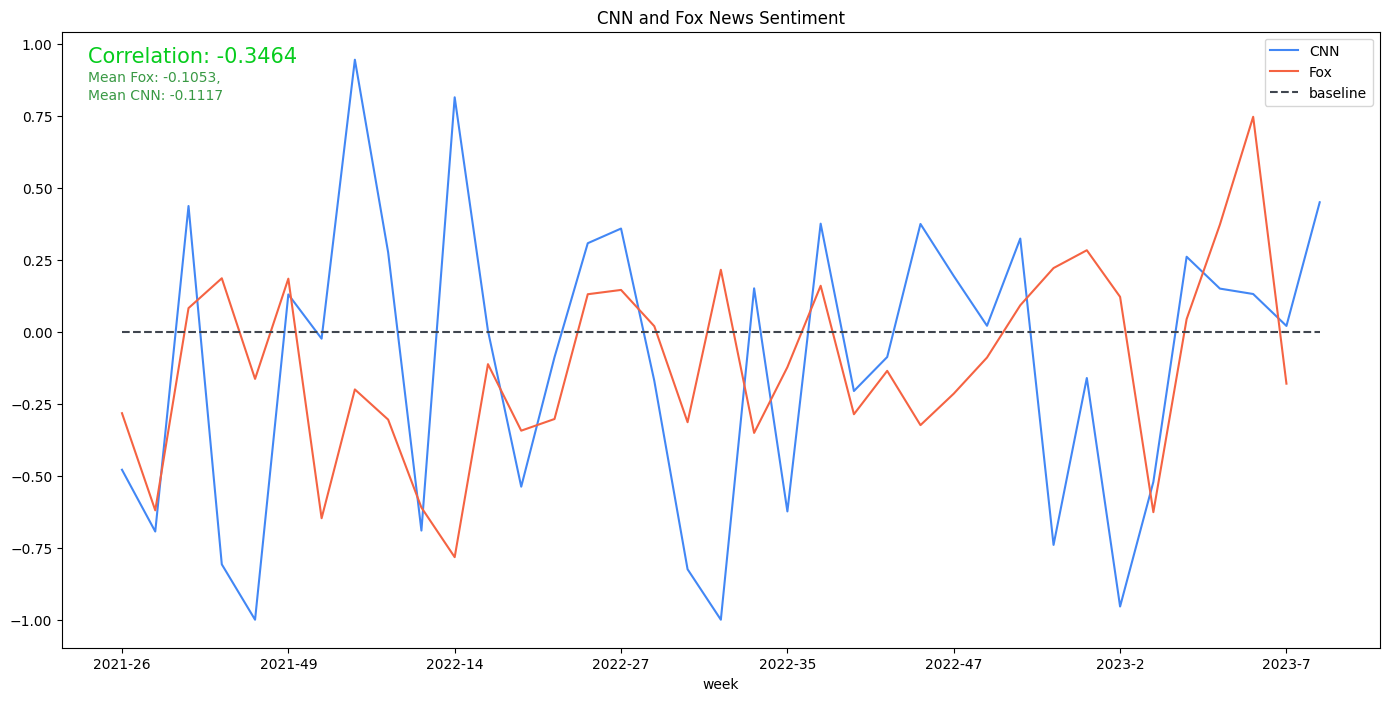

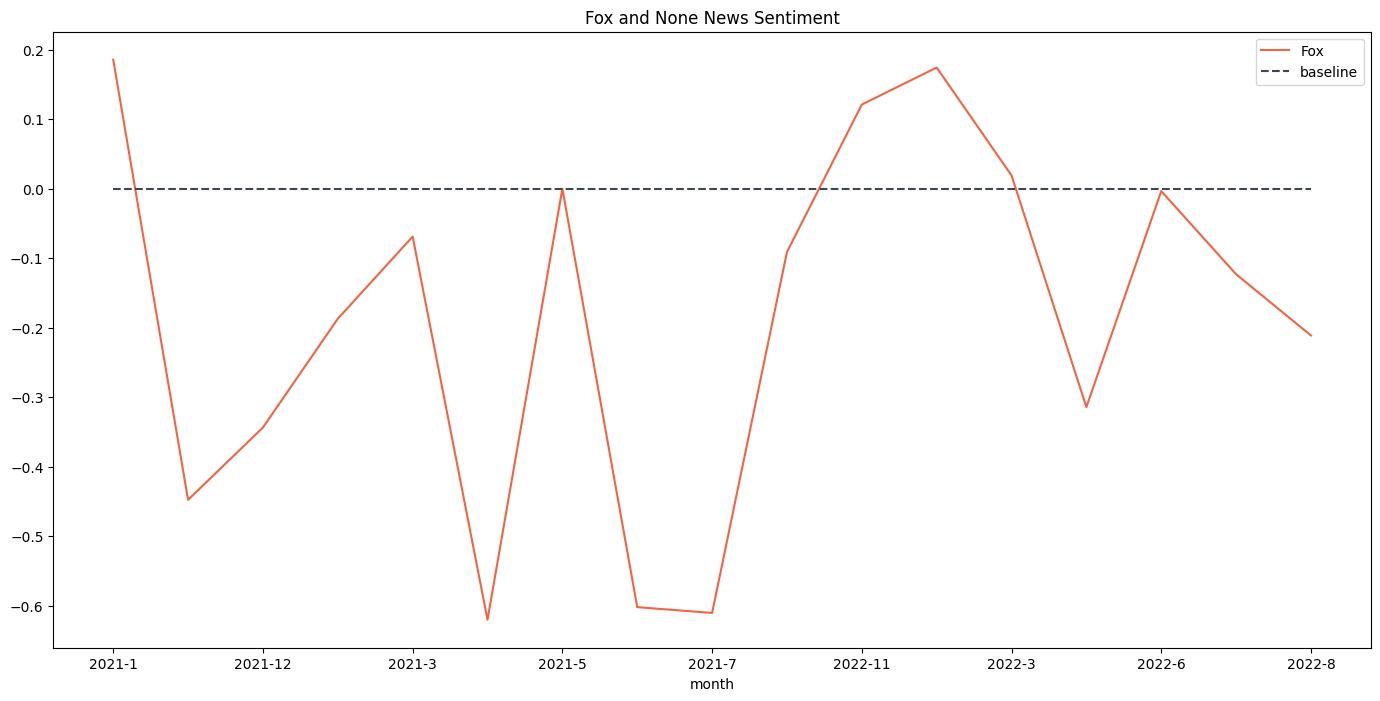

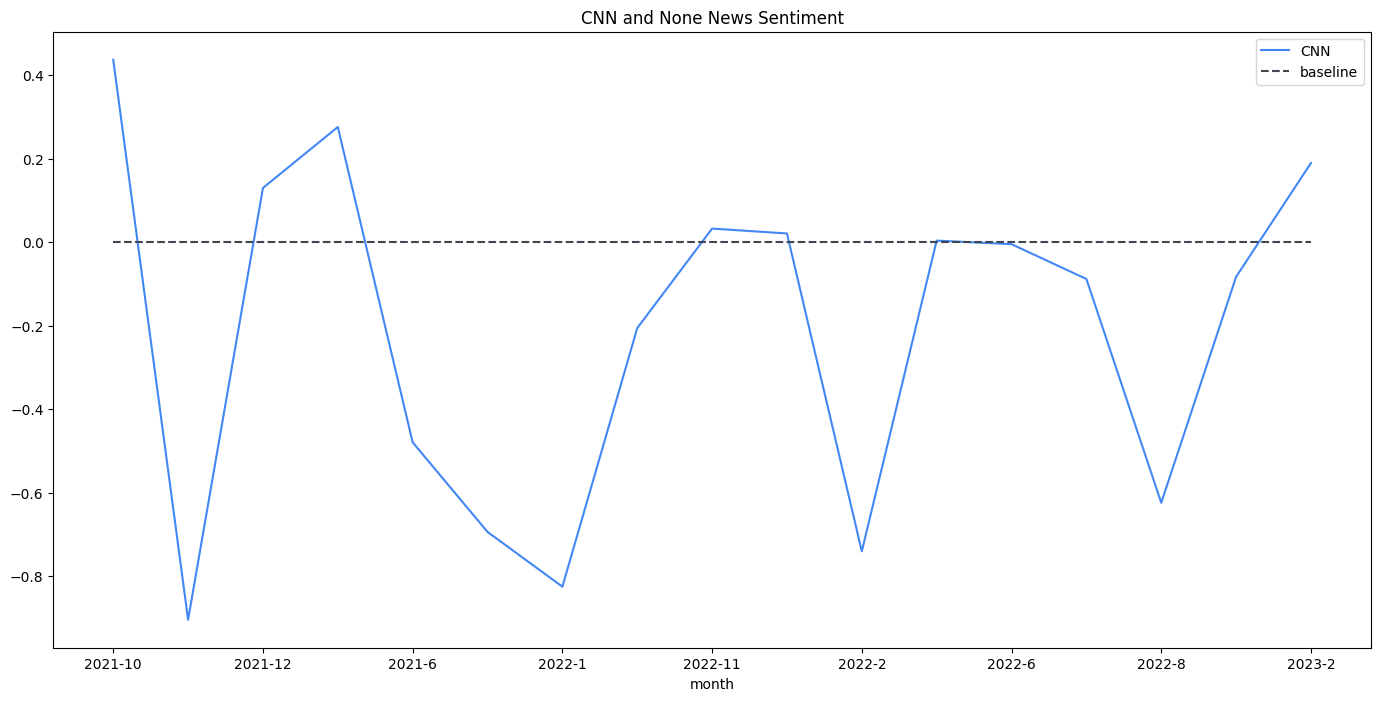

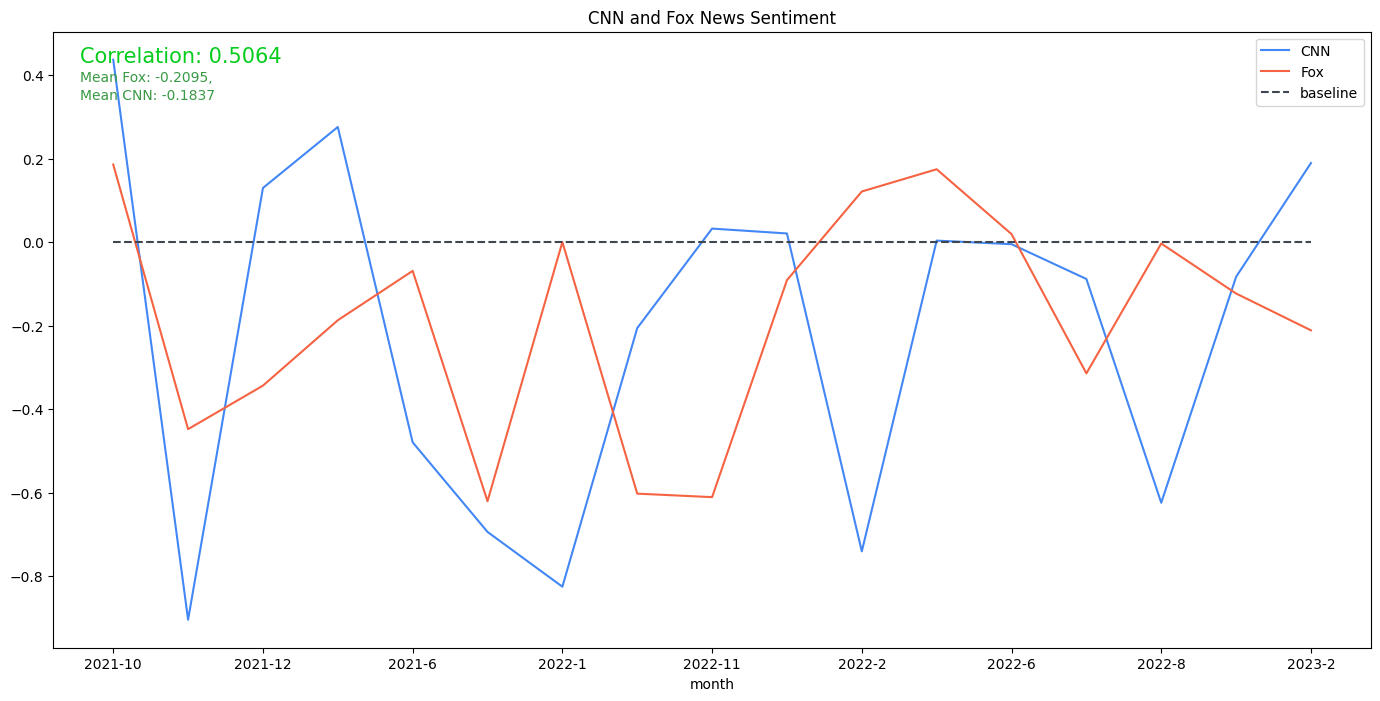

In [66]:
def monthly_avg_plot(df1:pd.DataFrame, vendor1, color='#4287f5', df2:pd.DataFrame = None, vendor2=None, color2='#f56342'):
            
            df1['date'] = pd.to_datetime(df1['date'])
            df1 = df1.sort_values(by=['month'], ascending=True)
            df1 = df1.groupby('month').median().rename(columns={'compound_s': vendor1})
            axes = df1.plot(y=vendor1, kind='line',
                             title=f'{vendor1} and {vendor2} News Sentiment', color=color , figsize=(17,8))
            if (df2 is not None):
                df2['date'] = pd.to_datetime(df2['date'])
                df2 = df2.sort_values(by=['month'], ascending=True)
                df2 = df2.groupby('month').median().rename(columns={'compound_s': vendor2})
                correlation = df2[vendor2].corr(df1[vendor1])
                mean1 = df1[vendor1].mean()
                mean2 = df2[vendor2].mean()

                df2.plot(y=vendor2, kind='line', ax=axes, color=color2)
                add_data_to_plot(axes, vendor1, vendor2, mean1, mean2, correlation)

            pd.DataFrame({'month': df1.index, 'baseline': [0.0]*len(df1)}).plot(
                    x='month', y='baseline', kind='line', ax=axes, color='#40464f', linestyle='--')

def weekly_avg_plot(df1:pd.DataFrame, vendor1, color='#4287f5', df2:pd.DataFrame = None, vendor2=None, color2='#f56342'):       
                df1['date'] = pd.to_datetime(df1['date'])
                df1 = df1.sort_values(by=['week'], ascending=True)
                df1 = df1.groupby('week').median().rename(columns={'compound_s': vendor1})
                axes = df1.plot(y=vendor1, kind='line', title=f'{vendor1} and {vendor2} News Sentiment', color=color , figsize=(17,8))

                if (df2 is not None):
                    df2['date'] = pd.to_datetime(df2['date'])
                    df2 = df2.sort_values(by=['week'], ascending=True)
                    df2 = df2.groupby('week').median().rename(columns={'compound_s': vendor2})
                    correlation = df2[vendor2].corr(df1[vendor1])
                    mean1 = df1[vendor1].mean()
                    mean2 = df2[vendor2].mean()
                    add_data_to_plot(axes, vendor1, vendor2, mean1, mean2, correlation)
    
                    df2.plot(y=vendor2, kind='line', ax=axes, color=color2)
                pd.DataFrame({'week': df1.index, 'baseline': [0.0]*len(df1)}).plot(x='week', y='baseline', kind='line', ax=axes, color='#40464f', linestyle='--')
    


weekly_avg_plot(cnn, 'CNN')
weekly_avg_plot(fox, 'Fox', color='#f56342')
weekly_avg_plot(cnn, 'CNN', df2=fox, vendor2='Fox', color2='#f56342')
monthly_avg_plot(fox, 'Fox', color='#f56342')
monthly_avg_plot(cnn, 'CNN')
monthly_avg_plot(cnn, 'CNN', df2=fox, vendor2='Fox', color2='#f56342')



## 3000 trump articles
